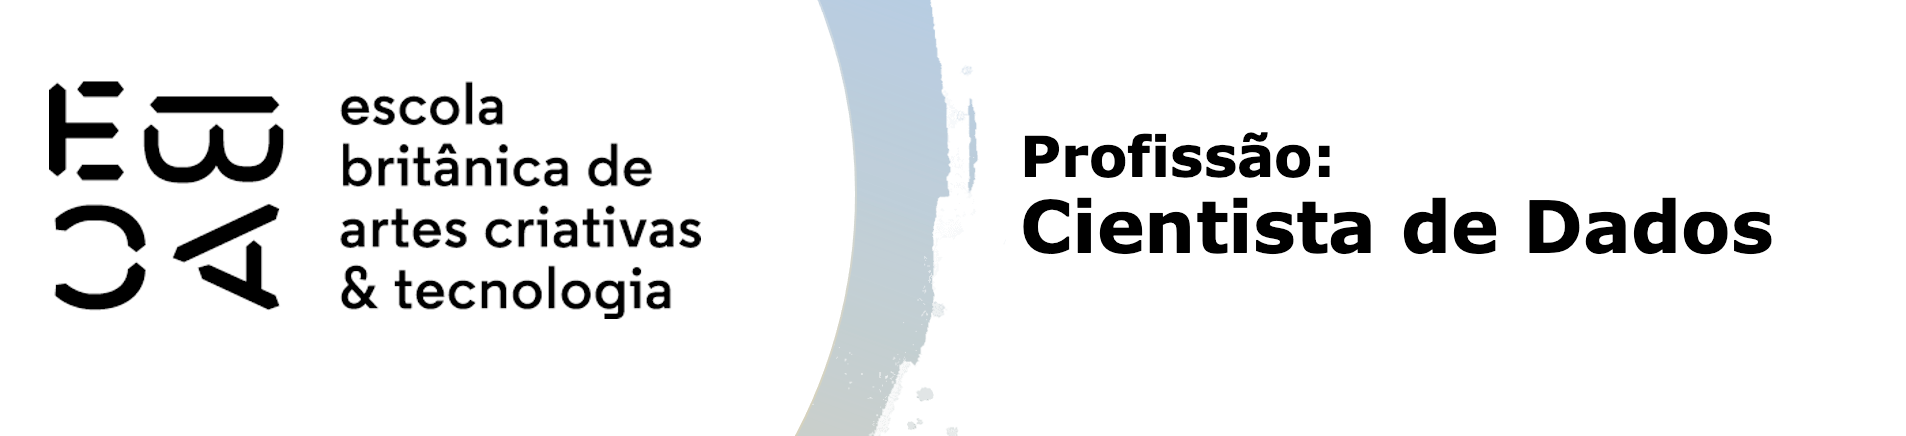

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
#Importação das Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from script import analise
from script import IV
from script import biv_discreta
from script import biv_continua

%reload_ext watermark
%watermark -iv -v

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

statsmodels: 0.14.1
sklearn    : 1.4.1.post1
numpy      : 1.26.4
pandas     : 2.2.1
matplotlib : 3.8.3
plotly     : 5.20.0
seaborn    : 0.13.2



In [2]:
meses = {1:  'Jan',
         2:  'Fev',
         3:  'Mar',
         4:  'Abr',
         5:  'Mai',
         6:  'Jun',
         7:  'Jul',
         8:  'Ago',
         9:  'Set',
         10: 'Out',
         11: 'Nov',
         12: 'Dez'}

In [14]:
#Lendo CSV e Tratamento dos Dados.

credit_scoring = pd.read_feather('./Dados/credit_scoring.ftr')

df = credit_scoring.copy()
df.drop(columns='index', inplace=True)
df.fillna({'tempo_emprego': -1}, inplace=True)
df.set_index(keys='data_ref', inplace=True)
df.index = df.index.month.map(meses) + '_' + df.index.year.astype(str)
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,
Jan_2015,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
Jan_2015,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
Jan_2015,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
Jan_2015,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
Jan_2015,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [15]:
#Definindo o DataFrame de Treino e de Test(Validação).

df_train = df.loc[~df.index.isin(['Jan_2016', 'Fev_2016', 'Mar_2016'])]
df_test = df.loc[df.index.isin(['Jan_2016', 'Fev_2016', 'Mar_2016'])]
print(f'\033[1;92mDF_TRAIN:\033[0;1m\n{df_train.index.value_counts()}')
print('-'*25)
print(f'\033[1;94mDF_TEST:\033[0;1m\n{df_test.index.value_counts()}')

DF_TRAIN:
data_ref
Jan_2015    50000
Fev_2015    50000
Mar_2015    50000
Abr_2015    50000
Mai_2015    50000
Jun_2015    50000
Jul_2015    50000
Ago_2015    50000
Set_2015    50000
Out_2015    50000
Nov_2015    50000
Dez_2015    50000
Name: count, dtype: int64
-------------------------
DF_TEST:
data_ref
Jan_2016    50000
Fev_2016    50000
Mar_2016    50000
Name: count, dtype: int64


In [16]:
#Analise do DataFrame

analise_df = analise(df, y='mau')
analise_df

,dtype,contagem,missing,nunique,papel
sexo,object,750000,0,2,covariavel
posse_de_veiculo,object,750000,0,2,covariavel
posse_de_imovel,object,750000,0,2,covariavel
qtd_filhos,int64,750000,0,8,covariavel
tipo_renda,object,750000,0,5,covariavel
educacao,object,750000,0,5,covariavel
estado_civil,object,750000,0,5,covariavel
tipo_residencia,object,750000,0,6,covariavel
idade,int64,750000,0,47,covariavel
tempo_emprego,float64,750000,0,3005,covariavel


PERCENTUAL "mau":
mau
False    0.921809
True     0.078191
Name: proportion, dtype: float64
--------------------------------
CONTAGEM "mau":
mau
False    691357
True      58643
Name: count, dtype: int64


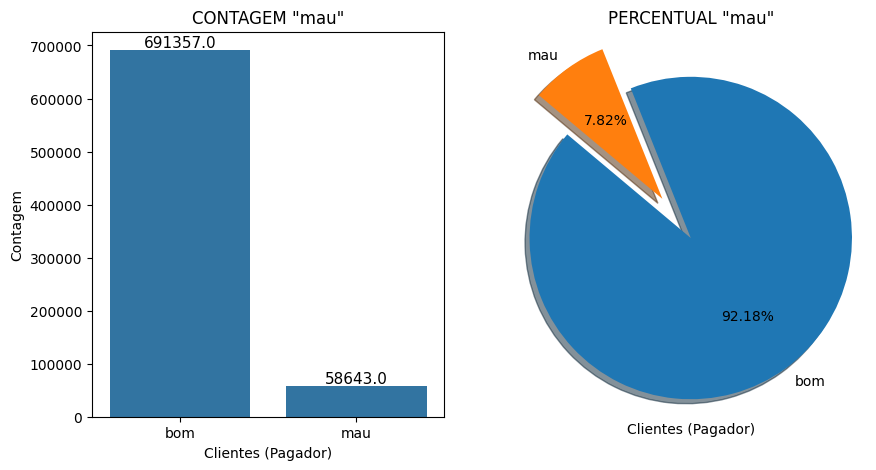

In [17]:
#Analisando os "mau" Pagadores

print(f'\033[1;94mPERCENTUAL "mau":\n\033[0m{df.mau.value_counts(normalize=True)}')
print('-'*32)
print(f'\033[1;92mCONTAGEM "mau":\n\033[0m{df.mau.value_counts()}')

fig, axes = plt.subplots(1,2, figsize=(10,5))

ax1 = sns.barplot(df.mau.map({True: 'mau', False: 'bom'}).value_counts(), ax=axes[0])
ax1.set_title('CONTAGEM "mau"')
ax1.set_xlabel('Clientes (Pagador)')
ax1.set_ylabel('Contagem')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

ax2 = plt.pie(df.mau.map({True: 'mau', False: 'bom'}).value_counts(normalize=True), explode=(0, 0.3), labels=['bom', 'mau'], autopct='%1.2f%%', shadow=True, startangle=140)
plt.title('PERCENTUAL "mau"')
plt.xlabel('Clientes (Pagador)')
plt.axis('equal')

plt.show()

In [25]:
for var in analise_df[analise_df.papel=='covariavel'].index:
    if  (analise_df.loc[var, 'nunique']>50):
        analise_df.loc[var, 'IV'] = IV(pd.qcut(df[var],15,duplicates='drop'), df.mau)
    else: 
        analise_df.loc[var, 'IV'] = IV(df[var], df.mau)
    
analise_df.sort_values(by='IV', ascending=False, inplace=True)
analise_df

,dtype,contagem,missing,nunique,papel,IV
qt_pessoas_residencia,float64,750000,0,9,covariavel,inf
renda,float64,750000,0,142419,covariavel,1.192576
tempo_emprego,float64,750000,0,3005,covariavel,0.312302
idade,int64,750000,0,47,covariavel,0.024717
posse_de_imovel,object,750000,0,2,covariavel,0.009693
tipo_renda,object,750000,0,5,covariavel,0.009360
educacao,object,750000,0,5,covariavel,0.003547
tipo_residencia,object,750000,0,6,covariavel,0.003045
sexo,object,750000,0,2,covariavel,0.002185
qtd_filhos,int64,750000,0,8,covariavel,0.001631


In [26]:
print(f'\033[1;7mInformation Value (IV):\033[0m\n{"-"*36}')

for i, j in zip(analise_df.index, analise_df.IV):
    if j > 0.5:
        print(f'\033[1m{i}:\033[0m\033[1;91m {j:.3f} (Suspeito de tão alto)\033[0m\n{"-"*36}')
    elif j > 0.3:
        print(f'\033[1m{i}:\033[0m\033[1;94m {j:.3f} (Forte)\033[0m\n{"-"*36}')
    elif j > 0.1:
        print(f'\033[1m{i}:\033[0m\033[1;92m {j:.3f} (Médio)\033[0m\n{"-"*36}')
    elif j > 0.02:
        print(f'\033[1m{i}:\033[0m\033[1;93m {j:.3f} (Fraco)\033[0m\n{"-"*36}')
    else:
        print(f'\033[1m{i}:\033[0m\033[1;91m {j:.3f} (Inútil)\033[0m\n{"-"*36}')

Information Value (IV):
------------------------------------
qt_pessoas_residencia: inf (Suspeito de tão alto)
------------------------------------
renda: 1.193 (Suspeito de tão alto)
------------------------------------
tempo_emprego: 0.312 (Forte)
------------------------------------
idade: 0.025 (Fraco)
------------------------------------
posse_de_imovel: 0.010 (Inútil)
------------------------------------
tipo_renda: 0.009 (Inútil)
------------------------------------
educacao: 0.004 (Inútil)
------------------------------------
tipo_residencia: 0.003 (Inútil)
------------------------------------
sexo: 0.002 (Inútil)
------------------------------------
qtd_filhos: 0.002 (Inútil)
------------------------------------
estado_civil: 0.001 (Inútil)
------------------------------------
posse_de_veiculo: 0.000 (Inútil)
------------------------------------
mau: nan (Inútil)
------------------------------------


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

c:\Users\Eduardo\Documents\EBAC-Exercicios\Exercício_Cientista_de_dados_Módulo37\Exercício 2\script.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


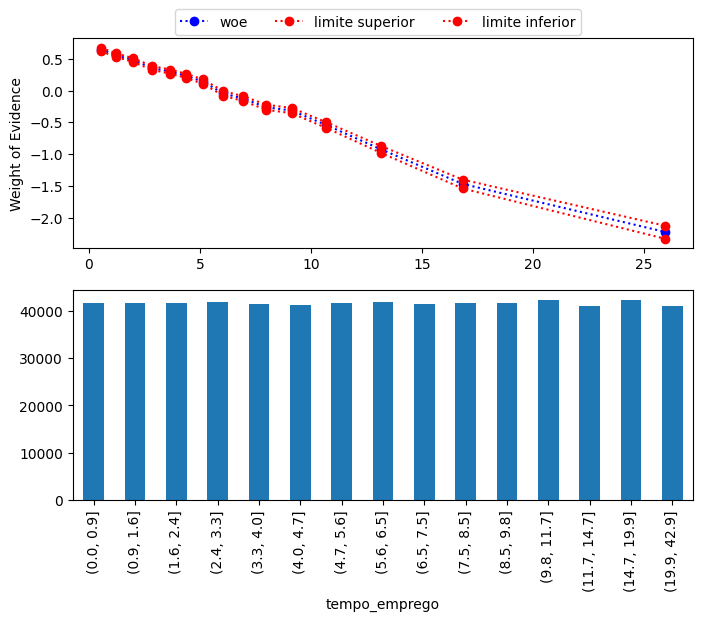

In [9]:
biv_continua('tempo_emprego', 15, df)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.